In [57]:
import pandas as pd #dataframes
import numpy as np
import matplotlib.pyplot as plt #to plot stuff
%matplotlib inline
import seaborn as sns
from scipy import stats #so statistical test Kruskal and one sample t test
import statsmodels.api as sm #to run ANOVA
from statsmodels.formula.api import ols #to create fit for ANOVA
import scikit_posthocs as sp #to run DUNN test after Kruskal - I cannot get it to work so far


### Import tables needed to analyze significance

In [58]:
course_offerings = pd.read_csv('course_offerings.csv')
# course_offerings.head()
# course_offerings.shape
# course_offerings.info()
# course_offerings.uuid.value_counts() # unique 81452
# course_offerings.course_uuid.value_counts() #9306 not unique
# course_offerings.name.value_counts()

In [59]:
sections = pd.read_csv('sections.csv')
# sections.head()
# sections.tail()
# sections.info()
# sections.info()
sections = sections.set_index('course_offering_uuid')
# ^ change index to join later

In [60]:
grade_dist = pd.read_csv('grade_distributions.csv')
# grade_dist.head()
# grade_dist.shape
# grade_dist.tail()
# grade_dist.course_offering_uuid.value_counts()
# grade_dist.info()
# grade_dist = grade_dist.set_index('course_offering_uuid')

In [61]:
sched = pd.read_csv('schedules.csv')
# sched.head()
# sched.info()
# sched.loc[sched['start_time']==-1].shape[0] ####19 entires have a weird -1 start and end time
# sched['start_time'].max()
#subset the df to only contain the rows with reasonable start and end times
sched = sched.loc[(sched['start_time']>=0) & (sched['start_time']<=24*60)]
sched = sched.loc[(sched['end_time']>=0) & (sched['end_time']<=24*60)]
# sched.end_time.unique()

sched = sched[['uuid','start_time', 'end_time']]
# sched.head()
sched = sched.set_index('uuid')

### Merge and Join tables to get one useful table 

Since our analysis is based off of grade distribution we want to use this as our basis of data points. We merge on the two common columns in grade distribution and sections: course_offring_uuid and section_name/number. 

In [62]:
#merge the dfs 
grade_sec = grade_dist.merge(sections, left_on=['course_offering_uuid', 'section_number'], right_on=['course_offering_uuid','number'], how='left')
# grade_sec.info()
# grade_sec.head()

We join this new table which has grade and section data to schedule table on the common value schdule_uuid. 

In [63]:
grade_sec_sched = grade_sec.join(sched, on='schedule_uuid', how='left')
# grade_sec_sched .info()

Rename column name uuid to section_uuid so we don't get confused with the uuids in our table so far

In [64]:
#rename uuid to section_uuid for no confusion
grade_sec_sched = grade_sec_sched.rename(columns={"uuid": "section_uuid"})

Join this table with course offrings table on course_offering_uuid to obtain course name 

In [65]:
#set index as uuid to merge with grade_sec_schd 
course_offerings = course_offerings.set_index('uuid')

grade_sec_sched_name = grade_sec_sched.join(course_offerings, on='course_offering_uuid', how='left')
# grade_sec_sched_name.head()
# grade_sec_sched_name.info()
# grade_sec_sched_name.iloc[:,]
grade_sec_sched_name['total_count'] = grade_sec_sched_name.iloc[:,2:8].sum(axis=1)


# grade_sec_sched_name['a_count'] 
# grade_sec_sched_name[['a_count', 'total_count']]
grade_sec_sched_name['a_percent'] = grade_sec_sched_name['a_count'] / grade_sec_sched_name['total_count'] 
grade_sec_sched_name[['a_count', 'total_count', 'a_percent']].head()

,a_count,total_count,a_percent
0,105,105,1.000000
1,158,158,1.000000
2,139,156,0.891026
3,139,156,0.891026
4,139,156,0.891026


In [66]:
#save the df for easy respawn
grade_sec_sched_name.to_csv('grade_sec_sched_name.csv')

Create our minimal dataframe we need for our analysis.

In [67]:
As_by_time = pd.DataFrame()

for col in 'name start_time a_percent'.split():
    As_by_time[col] = grade_sec_sched_name[col]

As_by_time = As_by_time.dropna() 

### Check the A_percent data for normality 

To analyze the distribution of the ppercentage of A's given I called basic histogram. From a quick glance it is easy to see that the distribution seems to be bimodal.

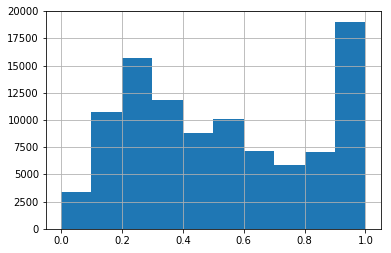

In [68]:
As_by_time.a_percent.hist()

To investigate further I called a probplot or QQ plot to determine normality. This data is not normally distributed. 

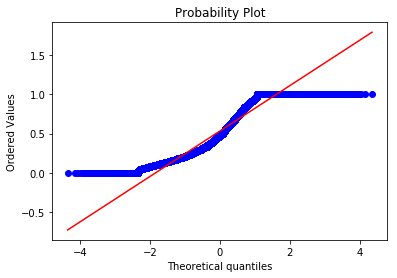

In [69]:
stats.probplot(As_by_time.a_percent, dist = "norm", plot=plt);

### Exploring non normality
Since the data does not follow a normal distribution I want to investigate the times of days more closely. In order to do so I subset the data into four categories
* Morning: 6:00 AM - 9:30 AM
* Noon: 10:00 AM - 1:30 PM
* Aftrnoon: 2:00 PM - 5:00 PM
* Evening: 5:30 PM - 9:00 PM

Using these groupsing I plotted their KDE's against the population KDE for comparison


In [70]:
As_by_time['by_hour'] = As_by_time.start_time / 60 #put the start time into relative hours
As_by_time = As_by_time[As_by_time['by_hour'] >= 6] #drops a few outlying data points 

#function to subset the dataframe by time of day
def time_of_day(x):
    if  6<= x<=9.5:
        return "1"# morning
    elif 10<= x<=13.5:
        return "2" #noon
    elif 14<= x<=17:
        return "3" #afternoon
    elif 17.5<= x<=21:
        return "4" #evening
    
As_by_time['time_of_day'] = As_by_time['by_hour'].apply(lambda x: time_of_day(x) )

In [71]:
#check the number of data points in each category
As_by_time['time_of_day'].value_counts()
# 2    39761
# 3    25792
# 1    22221
# 4     4238

#create subset dataframes
As_by_time_M = As_by_time[As_by_time['time_of_day'] == '1']
As_by_time_N = As_by_time[As_by_time['time_of_day'] == '2']
As_by_time_AN = As_by_time[As_by_time['time_of_day'] == '3']
As_by_time_E = As_by_time[As_by_time['time_of_day'] == '4']


Because I have a lot of unequal sized  data, I will take a random sample of equal size from each subset for further analysis.

In [72]:
M_samp = As_by_time_M.a_percent.sample(n=2500, random_state = 1)
N_samp = As_by_time_N.a_percent.sample(n=2500, random_state = 1)
AN_samp = As_by_time_AN.a_percent.sample(n=2500, random_state = 1)
E_samp = As_by_time_E.a_percent.sample(n=2500, random_state = 1)

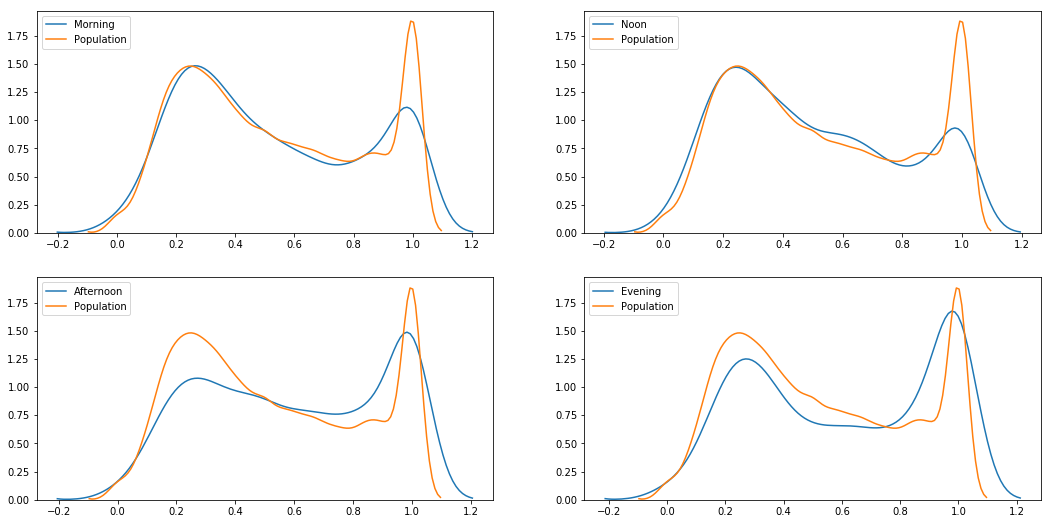

In [73]:

fix, ax = plt.subplots(2,2,figsize=(18,9))
for i, a in enumerate([M_samp, N_samp, AN_samp, E_samp]):
    labels = ["Morning", "Noon", "Afternoon", "Evening"]
    sns.kdeplot(a, ax = ax[i//2,i%2], label = labels[i])
    sns.kdeplot(As_by_time.a_percent, ax = ax[i//2,i%2], label = "Population")
plt.savefig('TimeofDay4.jpg')
plt.show()

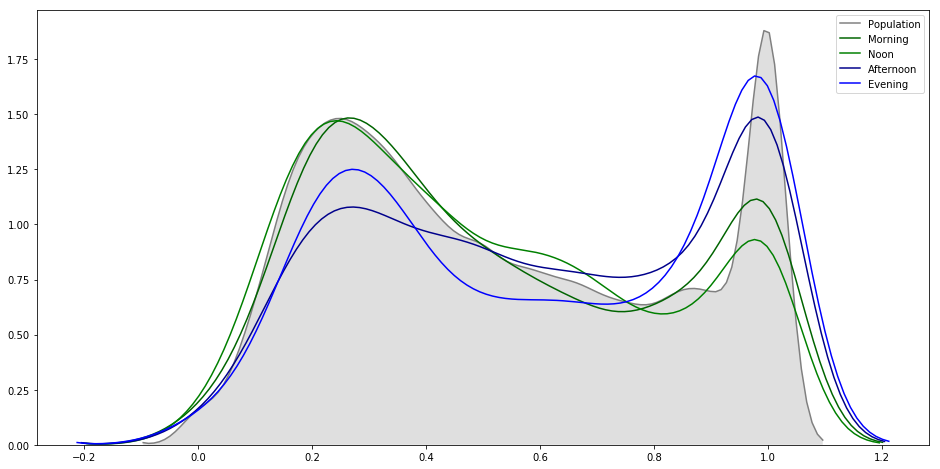

In [74]:
fig, ax = plt.subplots(figsize=(16,8))

sns.kdeplot(As_by_time.a_percent,  ax=ax, color="gray", label = "Population", shade = True)
sns.kdeplot(M_samp,  ax=ax, color="darkgreen", label = "Morning")
sns.kdeplot(N_samp,  ax=ax, color="green", label = "Noon")
sns.kdeplot(AN_samp,  ax=ax, color="darkblue", label = "Afternoon")
sns.kdeplot(E_samp,  ax=ax, color="blue", label = "Evening")
plt.savefig('TimeofDay1.jpg')

## Question 1: Does time of day have a statistically significant correlation with number of A's earned in courses?
### Hypothesis Testing

From both visualizations we can see the distributions of Morning & Noon classes seem to be different than that of the Afternoon & Evening classes. Noticing this I will combine the Morning & Noon data and Aftrnoon & Evening data to test the following hypothesis:

$H_{o}: \mu_{m} = \mu_{e} $

The median ratio of A's given in classs from 6:00 AM - 1:30 PM is __equal__ to the ratios of A's given in classes from 2:00 - 9:00 PM

$H_{a}: \mu_{m} \neq \mu_{e} $

The median ratio of A's given in classs from 6:00 AM - 1:30 PM is __not equal__ to the ratios of A's given in classes from 2:00 - 9:00 PM


In [75]:
#combine the morning and noon data
Morning = pd.concat([M_samp, N_samp])
#combine the afternoon and evening courses
Evening = pd.concat([AN_samp, E_samp])


In [76]:
Mstats = pd.DataFrame(Morning.describe())
Mstats.rename(columns = { Mstats.columns[0] : "Morning" }, inplace = True)
Estats = pd.DataFrame(Evening.describe())
Estats.rename(columns = { Estats.columns[0] : "Evening" }, inplace = True)
MEstats = pd.concat([Mstats, Estats], axis = 1)
MEstats

,Morning,Evening
count,5000.000000,5000.000000
mean,0.515833,0.603260
std,0.298399,0.313204
min,0.000000,0.000000
25%,0.260020,0.312500
50%,0.454545,0.600000
75%,0.777778,0.933333
max,1.000000,1.000000


In [77]:
def WXRS(df1, df2):
    results = stats.ranksums(df1,df2)
    if results[1] < 0.5:
        print("We reject the null hypothesis with a Wilcoxon Rank Sum Statistic of: ", 
              results[0], ", and p-value of: ", results[1])
    elif results[1] >= 0.5:
        print("We fail to reject the null hypothesis with a Wilcoxon Rank Sum Statistic of: ", 
              results[0], ", and p-value of: ", results[1])

In [78]:
WXRS(Morning, Evening)

We reject the null hypothesis with a Wilcoxon Rank Sum Statistic of:  -13.856202106092834 , and p-value of:  1.1668688431715585e-43


### Conclusion 1

The median ratio of A's given in  Morning and Evening classes are not equal. Time of day is statistically significant factor in determing the number of A's arned in a course. 

Is there another underlying factor that is causing this significant change? Are the classes offered in the morning and night different? Are the class sizes of morning and night classes different? Are the class lengths different? 

## Question 3: Are STEM classes equally distributed over morning and evening classes?

### Import tables needed to determine STEM courses

In [79]:
#import subject_memberships table 
subject_mem = pd.read_csv('subject_memberships.csv')
subject_mem.head()
#reset index to course_offerings_uuid
subject_mem = subject_mem.set_index('course_offering_uuid')

#import subjects table
subj = pd.read_csv('subjects.csv')
# drop the non int categories, they each had 1 data point 
subj = subj[subj['code'] !='ZZZ']
subj = subj[subj['code'] !='SAB']
#retype as integer to get ready for join 
subj.code = subj.code.astype(int)
#reset index to code for join 
subj = subj.set_index('code')

In [80]:
#join grade_sec_sched_name table wth subj mem table on course_offering_uuid
grade_sec_sched_name_subj = grade_sec_sched_name.join(subject_mem, on='course_offering_uuid', how='left')
#rename 'name' to course name because there is a name category in subj table
grade_sec_sched_name_subj = grade_sec_sched_name_subj.rename(columns={"name": "couse_name"})
# grade_sec_sched_name_subj.head()

In [81]:
#join grade_sec_sched_name_subj with subj table to get subj names
grade_sec_sched_name_subj = grade_sec_sched_name_subj.join(subj, on='subject_code', how='left')
grade_sec_sched_name_subj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245610 entries, 0 to 220120
Data columns (total 33 columns):
course_offering_uuid    245610 non-null object
section_number          245610 non-null int64
a_count                 245610 non-null int64
ab_count                245610 non-null int64
b_count                 245610 non-null int64
bc_count                245610 non-null int64
c_count                 245610 non-null int64
d_count                 245610 non-null int64
f_count                 245610 non-null int64
s_count                 245610 non-null int64
u_count                 245610 non-null int64
cr_count                245610 non-null int64
n_count                 245610 non-null int64
p_count                 245610 non-null int64
i_count                 245610 non-null int64
nw_count                245610 non-null int64
nr_count                245610 non-null int64
other_count             245610 non-null int64
section_uuid            242512 non-null object
section_type 

Make a sub sf with name, start_time and a_percent.
The data is not preclassified as STEM or not STEM. Using a value count series of subject names, I categorized each subject name as STEM or not. Saved in the csv titles - titles.csv

In [82]:
STEM = pd.DataFrame()
for col in 'name start_time a_percent'.split():
    STEM[col] = grade_sec_sched_name_subj[col]
STEM.dropna(inplace = True)
STEM.shape
titles = pd.DataFrame(STEM.name.value_counts())
titles.to_csv('titles.csv')

is_stem = pd.read_csv('titles - titles.csv')
# is_stem.set_index()
is_stem = is_stem.rename(columns={"Unnamed: 0": "name", "name": "counts"})
is_stem.head()
is_stem = is_stem.set_index("name")
#join is_STEM back with STEM
STEM = STEM.join(is_stem, on='name', how='left')

### Visualize distribution of stem courses over different times of the day

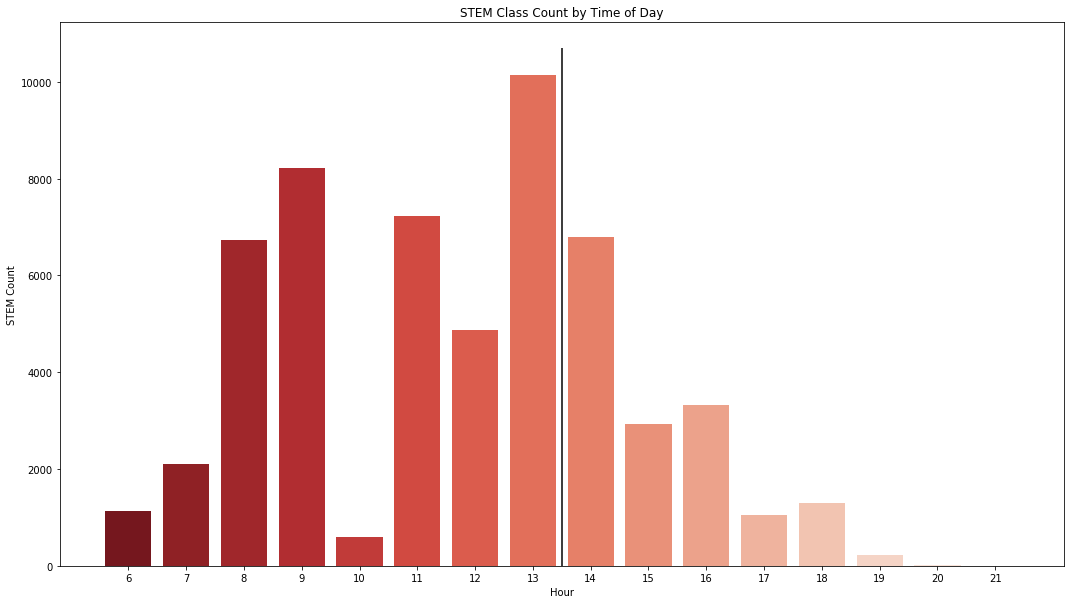

In [104]:
STEM['by_hour'] = STEM.start_time / 60
STEM = STEM[STEM['by_hour'] >= 6]
STEM.max()
STEM.by_hour = STEM.by_hour.astype(int)
STEM.head()

df_2 = pd.DataFrame(STEM.groupby('by_hour')['is_STEM'].sum())
df_2.reset_index(inplace=True)
df_2.head()
plt.figure(figsize=(18, 10))

ax = sns.barplot(x='by_hour', y='is_STEM', data=df_2, palette = "Reds_r")
plt.vlines(x = [ 7.5], ymin = 0, ymax = 10700, color = 'black')
ax.set(xlabel = "Hour", ylabel = "STEM Count")
ax.set_title("STEM Class Count by Time of Day")
plt.savefig('TimeSTEM1.jpg')

The black lines are represeting the time cut offs for the Morning, Noon, Afternoon, and Evening time blocks. It is easily seen that there are more STEM courses being offered in the Morning and Noon than in the Afternoon and Evening blocks.

## Question 3: Is there a relationship between time of day and if the course is STEM or not? 


In order to determine if there is association between the variables Time of Day and is_STEM we can run a Chi-square test of independence of variables. 

1. Take a random sample from the data
2. Determine the following counts from the sample:
    a. STEM & Morning
    b. Not STEM  & Morning
    c. STEM & Not Morning
    d. Not STEM & Not Morning
3. Store actual counts in observation variable by row
4. Run stats.chi2_contingency(obs) from SciPy library

$H_{o}:$ Time of Day and is STEM are independent 

$H_{a}:$ Time of Day and is STEM are not independent

In [84]:
#dataframe containing name state_time and A-percent 
Association = pd.DataFrame()
for col in 'name start_time a_percent'.split():
    Association[col] = grade_sec_sched_name_subj[col]
Association.dropna(inplace = True)

Association = Association.join(is_stem, on='name', how='left')
#cahnge minutes to hours
Association['by_hour'] = Association.start_time / 60
Association = Association[Association['by_hour'] >= 6]
#add column to track time of day 1 Morning 2 Noon 3 Afternoon 4 Evening
Association['time_of_day'] = Association['by_hour'].apply(lambda x: time_of_day(x) )
# Association.head()

In [85]:
#take a random sample from that df
asssamp = Association.sample(n=2500, random_state = 1)

In [86]:
#calculate the four values needed for the chi square independence test 

SM = len(asssamp[(asssamp.is_STEM == 1) & ((asssamp.time_of_day == '1' )|(asssamp.time_of_day == '2'))])#STEM and Morning
SNM = len(asssamp[(asssamp.is_STEM == 1) & ((asssamp.time_of_day == '3' )|(asssamp.time_of_day == '4'))])#STEM and Not Morning

NSM = len(asssamp[(asssamp.is_STEM == 0) & ((asssamp.time_of_day == '1' )|(asssamp.time_of_day == '2'))])#Not STEM and Morning
NSNM = len(asssamp[(asssamp.is_STEM == 0) & ((asssamp.time_of_day == '3' )|(asssamp.time_of_day == '4'))])#Not STEM and Not Morning

print(SM, SNM, NSM, NSNM)

783 322 765 432


In [87]:
#store actual value counts in variable by rows 
obs = ([[SM, NSM],[SNM, NSNM]])
obs

[[783, 765], [322, 432]]

In [88]:
#function to return results of test for easy read
def chi_ind(obs, alpha = .05, extended = False):
        g,p,dof,exval = stats.chi2_contingency(obs)
        if p < alpha:
            print("Reject the null hypothessis of no assicoation with a Chi-Squared Statistic of:", g, ", and p-value of:", p)
        elif p >= alpha:
            print("Fail to reject the null hypothessis of no assicoation with a Chi-Squared Statistic of:", g, ", and p-value of:", p)
        
        if extended:
            print("This Chi-Squared test has", dof, " degrees of freedom, and has the following expected values:", exval)

In [89]:
chi_ind(obs, extended = True)

Reject the null hypothessis of no assicoation with a Chi-Squared Statistic of: 12.286808905387554 , and p-value of: 0.0004561710435970704
This Chi-Squared test has 1  degrees of freedom, and has the following expected values: [[743.06689835 804.93310165]
 [361.93310165 392.06689835]]


In [90]:

Morning = asssamp[(asssamp.time_of_day == '1' )|(asssamp.time_of_day == '2')]
STEM1 = asssamp[asssamp['is_STEM'] == 1]

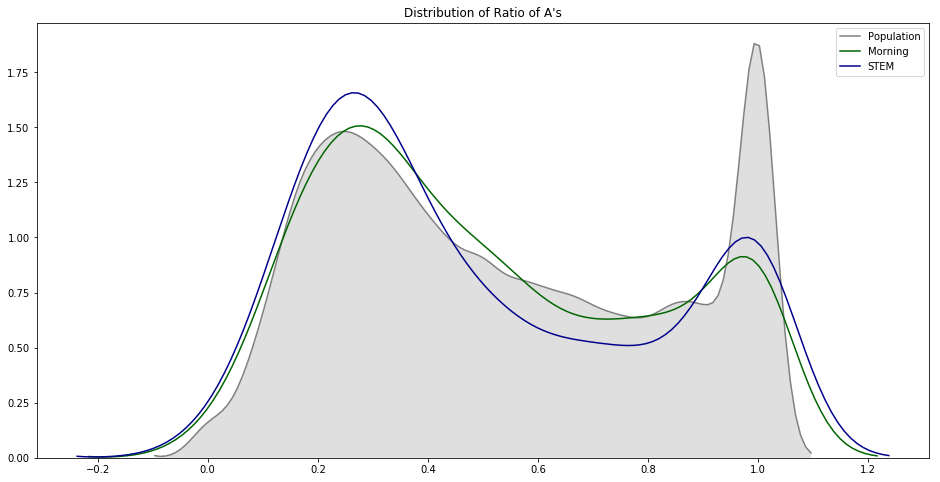

In [95]:
fig, ax = plt.subplots(figsize=(16,8))

sns.kdeplot(As_by_time.a_percent,  ax=ax, color="gray", label = "Population", shade = True)
sns.kdeplot(Morning.a_percent,  ax=ax, color="darkgreen", label = "Morning")
sns.kdeplot(STEM1.a_percent,  ax=ax, color="darkblue", label = "STEM")
ax.set_title("Distribution of Ratio of A's")
plt.savefig('TimeSTEM2.jpg')

### Conclusion 2

Examining a Chi-Square test for independence between Time of Day and is_STEM we can conclude that Time of Day and is_STEM are not indepenent of one another. 

## Question 2: Do STEM fields have a  statistically significant difference in the numbr of A's earned compared to the humanities?

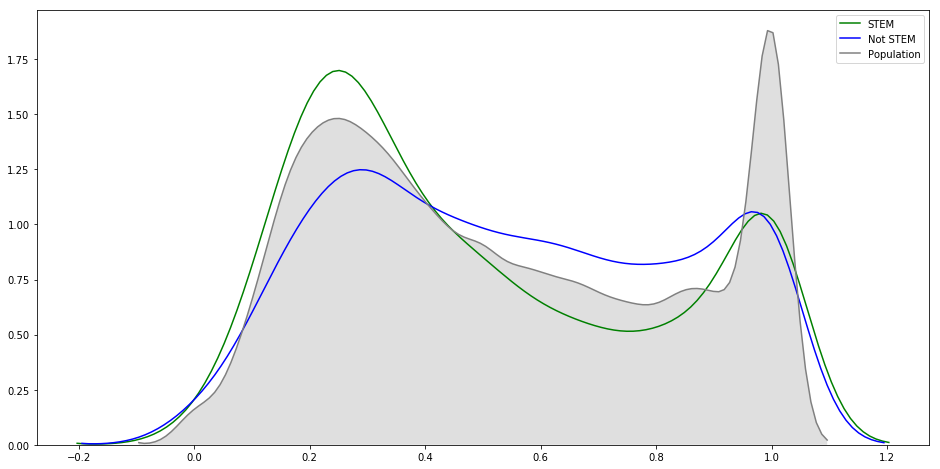

In [96]:
# fix, ax = plt.subplots(1,3,figsize=(24,6))
fig, ax = plt.subplots(figsize=(16,8))
labels = ["STEM","Not STEM"]
# sns.kdeplot(isSTEM, ax = ax[0], label = labels[0], color = "green")
# sns.kdeplot(As_by_time.a_percent, ax = ax[0], label = "Population", color = "black")
# sns.kdeplot(notSTEM, ax = ax[1], label = labels[1], color = "blue")
# sns.kdeplot(As_by_time.a_percent, ax = ax[1], label = "Population", color = "black")
sns.kdeplot(isSTEM, ax = ax, label = labels[0], color = "green")
sns.kdeplot(notSTEM, ax = ax, label = labels[1], color = "blue")
sns.kdeplot(As_by_time.a_percent, ax = ax, label = "Population", color = "gray", shade = True)
plt.savefig('isSTEM.jpg')
plt.show()

From both visualizations we can see the distributions of STEM seems to be different than that of the Humanities classes.

$H_{o}: \mu_{s} = \mu_{ns} $

The median ratio of A's given in STEM classes is __equal__ to the ratios of A's given in Humanities classes

$H_{a}: \mu_{s} \neq \mu_{ns} $

The median ratio of A's given in STEM classes is __not equal__ to the ratios of A's given in Humanities classes


In [97]:
AssociationisSTEM = Association[Association['is_STEM'] == 1]
AssociationnotSTEM = Association[Association['is_STEM'] == 0]
isSTEM = AssociationisSTEM.a_percent.sample(n=2500, random_state = 1)
notSTEM = AssociationnotSTEM.a_percent.sample(n=2500, random_state = 1)

In [98]:
WXRS(isSTEM, notSTEM)

We reject the null hypothesis with a Wilcoxon Rank Sum Statistic of:  -6.262297761593026 , and p-value of:  3.793456918074546e-10


## Questions 4: Are STEM courses statistically signifcant for # of A's given during Morning courses?
### If we hold Morning as a given will STEM still be statistically significant?

Make a sub df of just courses in the morning category. Break out into two subsets, STEM and not STEM

In [99]:
MorningSTEMtest = Association[(Association.time_of_day == '1' )|(Association.time_of_day == '2')]
MorningSTEMtest.info()
MorningSTEM = MorningSTEMtest.a_percent[MorningSTEMtest['is_STEM'] == 1 ]
MorningNSTEM = MorningSTEMtest.a_percent[MorningSTEMtest['is_STEM'] == 0 ]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74781 entries, 93 to 220117
Data columns (total 7 columns):
name           74781 non-null object
start_time     74781 non-null float64
a_percent      74781 non-null float64
counts         74781 non-null int64
is_STEM        74781 non-null int64
by_hour        74781 non-null float64
time_of_day    74781 non-null object
dtypes: float64(3), int64(2), object(2)
memory usage: 4.6+ MB


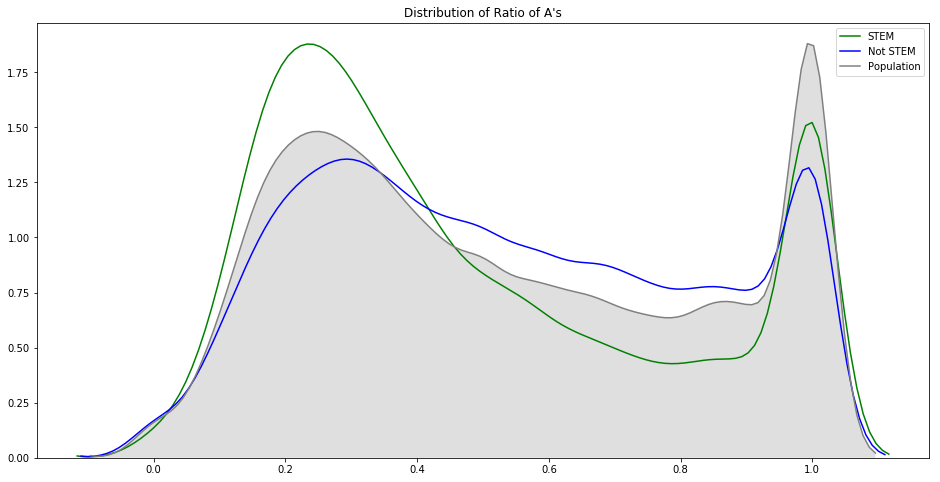

In [101]:
# fix, ax = plt.subplots(1,3,figsize=(24,6))
fig, ax = plt.subplots(figsize=(16,8))
labels = ["STEM","Not STEM"]
# sns.kdeplot(MorningSTEM, ax = ax[0], label = labels[0], color = "green")
# sns.kdeplot(As_by_time.a_percent, ax = ax[0], label = "Population", color = "black")
# sns.kdeplot(MorningNSTEM, ax = ax[1], label = labels[1], color = "blue")
# sns.kdeplot(As_by_time.a_percent, ax = ax[1], label = "Population", color = "black")
sns.kdeplot(MorningSTEM, ax = ax, label = labels[0], color = "green")
sns.kdeplot(MorningNSTEM, ax = ax, label = labels[1], color = "blue")
sns.kdeplot(As_by_time.a_percent, ax = ax, label = "Population", color = "gray", shade = True)
ax.set_title("Distribution of Ratio of A's")
plt.savefig('isSTEMM.jpg')
plt.show()

From both visualizations we can see the distributions of STEM seems to be different than that of the Humanities classes, even given both sets of classes being from the Morning category.

$H_{o}: \mu_{ms} = \mu_{mns} $

The median ratio of A's given in Morning STEM classes is __equal__ to the ratios of A's given in Morning Humanities classes

$H_{a}: \mu_{ms} \neq \mu_{mns} $

The median ratio of A's given in Morning STEM classes is __not equal__ to the ratios of A's given in Morning Humanities classes

In [103]:
WXRS(MorningSTEM, MorningNSTEM)


We reject the null hypothesis with a Wilcoxon Rank Sum Statistic of:  -28.061349943308684 , and p-value of:  2.9040034936081457e-173
